# Assess the Output of a Saved Model

This notebook allows you to load the weights of a trained U-Net model, pass data to it, and turn the model's output back in to audio, for subjective assessment against the original mixed and isolated signals.

In [1]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
import importlib
from datetime import datetime
import soundfile as sf

import audio_functions as af
import audio_models
import dataset

Using TensorFlow backend.


In [14]:
importlib.reload(audio_models)

<module 'audio_models' from '/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/audio_models.py'>

### Get the variables and data ready

In [15]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=16
normalise=True
batch_size = 1
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002
model_variant = 'noconvcapsunet'
data_type = 'real_imag'
phase_weight = 0.0005

checkpoint = '308/308-8'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Mixed'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Voice'
directory_c = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Background'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Voice'
#directory_c = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Background'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b, directory_c)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, background_spec, mixed_audio, voice_audio, background_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)
if data_type == 'mag':
    mixed_input = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
    voice_input = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)
elif data_type in ['mag_phase', 'mag_phase_diff']:
    mixed_input = mixed_spec[:, :, :-1, 2:4]
    voice_input = voice_spec[:, :, :-1, 2:4]
elif data_type == 'real_imag':
    mixed_input = mixed_spec[:, :, :-1, 0:2]
    voice_input = voice_spec[:, :, :-1, 0:2]
elif data_type in ['mag_real_imag', 'mag_phase2']:
    mixed_input = tf.concat([tf.expand_dims(mixed_spec[:, :, :-1, 2], 3), mixed_spec[:, :, :-1, 0:2]], 3)
    voice_input = tf.concat([tf.expand_dims(voice_spec[:, :, :-1, 2], 3), voice_spec[:, :, :-1, 0:2]], 3)
elif data_type in ['mag_phase_real_imag', 'complex_to_mag_phase']:
    mixed_input = mixed_spec[:, :, :-1, :]
    voice_input = voice_spec[:, :, :-1, :]
    
data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [16]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_input, voice_input, mixed_phase, mixed_audio, 
                                    voice_audio, background_audio, model_variant, is_training, learning_rate, 
                                    data_type, phase_weight, name='Magnitude_Model')
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(1)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

Creating model


### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [8]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/308/308-8


### Run a batch

In [9]:
sess.run(pipe.initializer)
mix_inp, mix_phase, voice_inp, voice_est, \
mask, voice_wave, mix_wave, background_wave = sess.run([model.mixed_input, 
                                                        model.mixed_phase, 
                                                        model.voice_input,
                                                        model.gen_voice, 
                                                        model.voice_mask, 
                                                        model.voice_audio, 
                                                        model.mixed_audio,
                                                        model.background_audio],
                                                       {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

for i in range(voice_inp.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est[i, :, :, 0]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)


In [10]:
# Infer the estimated background noise by subtracting estimated voice from mixed signal

for i in range (voice_wave.shape[0]):
    voice_wave[i,:,:] = af.normalise_audio(voice_wave[i,:,:])
    voice_est_wave[i,:,:] = af.normalise_audio(voice_est_wave[i,:,:])
    mix_wave[i,:,:] = af.normalise_audio(mix_wave[i,:,:])
    background_wave[i,:,:] = af.normalise_audio(background_wave[i,:,:])

bg_est_wave = mix_wave - voice_est_wave

# Calculate audio metrics for the batch
ref_sources = []
est_sources = []
mixed_sources = []
sdrs = np.empty((0, 2))
sirs = np.empty((0, 2))
sars = np.empty((0, 2))
nsdrs = np.empty((0, 2))
for i in range(len(voice_est_wave)):
    ref_sources.append(np.concatenate((voice_wave[i], background_wave[i]), axis=1))
    est_sources.append(np.concatenate((voice_est_wave[i], bg_est_wave[i]), axis=1))
    mixed_sources.append(np.concatenate((mix_wave[i], mix_wave[i]), axis=1))
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, est_sources[i].T, compute_permutation=False)
    sdr_mr, _, _, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, mixed_sources[i].T, compute_permutation=False)
    nsdr = sdr - sdr_mr
    sdrs = np.concatenate((sdrs, np.expand_dims(sdr, 1).T), axis=0)
    sirs = np.concatenate((sirs, np.expand_dims(sir, 1).T), axis=0)
    sars = np.concatenate((sars, np.expand_dims(sar, 1).T), axis=0)
    nsdrs = np.concatenate((nsdrs, np.expand_dims(nsdr, 1).T), axis=0)

print('Metrics (voice, background):\nSDR\n',
      sdrs, '\nSIR\n', sirs, '\nSAR\n', sars, '\nNSDR\n', nsdrs)

/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Metrics (voice, background):
SDR
 [[7.37409165 8.99826347]] 
SIR
 [[14.49119157 14.27395625]] 
SAR
 [[ 8.46364221 10.68670096]] 
NSDR
 [[4.24281771 5.21860103]]


### Waveform and Mask Comparisons

The following set of cells were used to create the figure entitled "Waveform and Mask Comparisons" in the project report. For each of the next four cells, the network identified by the experiment ID provided was loaded using the cells above and a sample output stored. When the four samples were ready the fifth cell was run to roduce the figure.

In [11]:
#234
unet_out = voice_est_wave
unet_mask = mask
unet_sdr = round(sdrs[0][0], 3)

In [18]:
#279
capsunet_out = voice_est_wave
capsunet_mask = mask
capsunet_sdr = round(sdrs[0][0], 3)

In [24]:
#284
basic_conv_out = voice_est_wave
basic_conv_mask = mask
basic_conv_sdr = round(sdrs[0][0], 3)

In [30]:
#266
basic_caps_out = voice_est_wave
basic_caps_mask = mask
basic_caps_sdr = round(sdrs[0][0], 3)

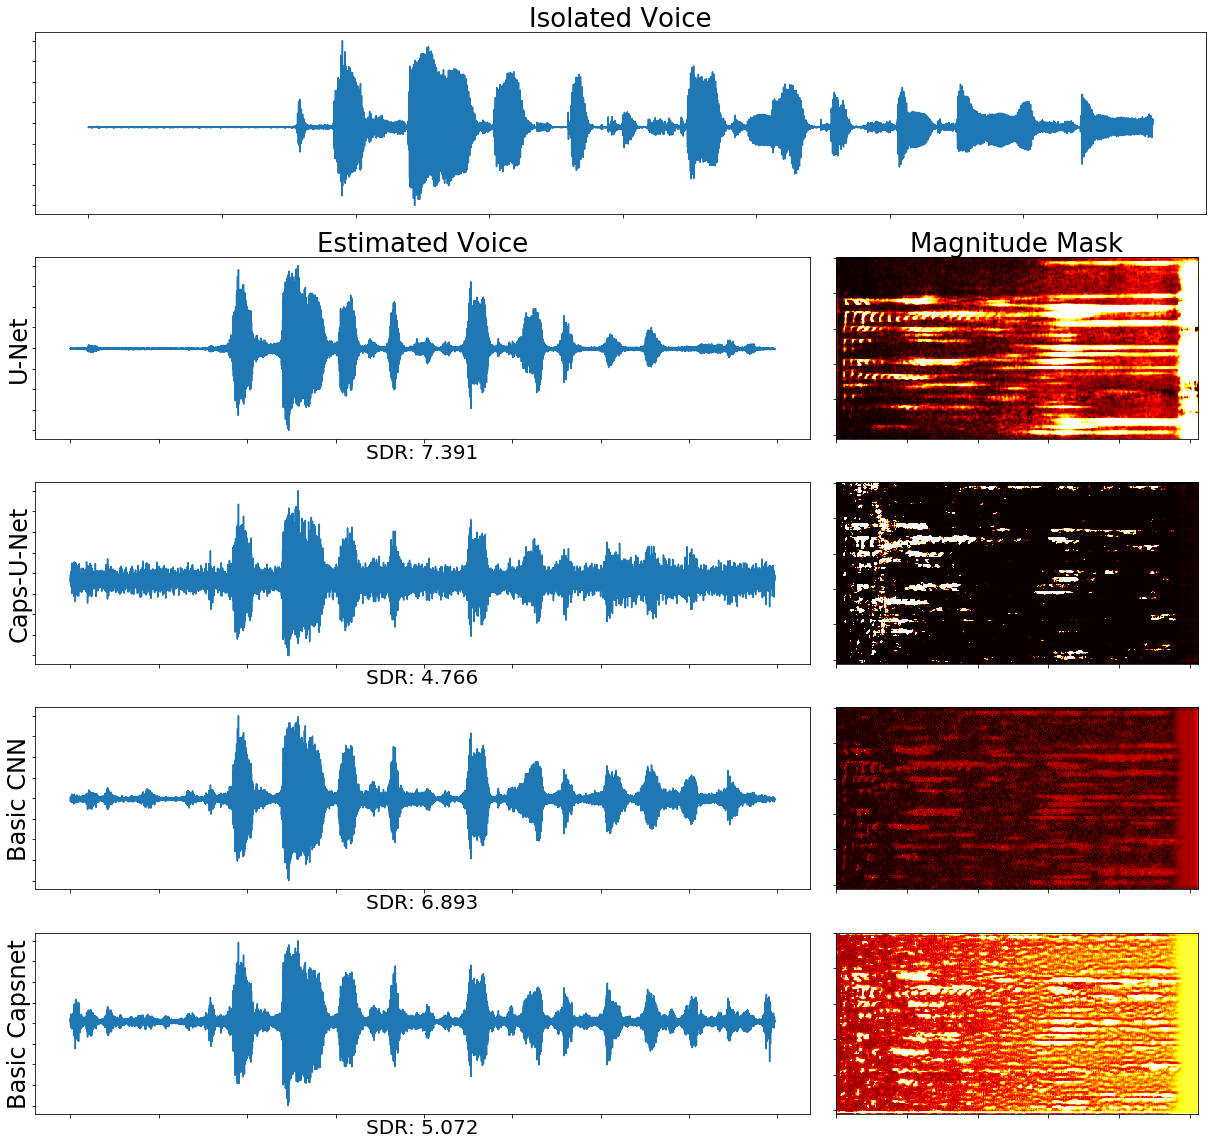

In [31]:
figs_folder = '/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/Notebooks/Figures'
i=0
x = np.array(range(len(voice_wave[i])))/sample_rate

plt.figure(figsize=(17,16))
ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((5, 3), (1, 0), colspan=2)
ax3 = plt.subplot2grid((5, 3), (1, 2), colspan=3)
ax4 = plt.subplot2grid((5, 3), (2, 0), colspan=2)
ax5 = plt.subplot2grid((5, 3), (2, 2), colspan=3)
ax6 = plt.subplot2grid((5, 3), (3, 0), colspan=2)
ax7 = plt.subplot2grid((5, 3), (3, 2), colspan=3)
ax8 = plt.subplot2grid((5, 3), (4, 0), colspan=2)
ax9 = plt.subplot2grid((5, 3), (4, 2), colspan=3)

ax1.plot(x,voice_wave[i])
ax1.set_title('Isolated Voice', fontsize=26)
ax2.plot(x,unet_out[i])
ax2.set_title('Estimated Voice', fontsize=26)
ax2.set_xlabel('SDR: {i}'.format(i=unet_sdr), fontsize=20)
ax2.set_ylabel('U-Net', fontsize=24)
ax3.imshow(unet_mask[i,:,:,0])
ax3.set_title('Magnitude Mask', fontsize=26)
ax4.plot(x,capsunet_out[i])
ax4.set_xlabel('SDR: {i}'.format(i=capsunet_sdr), fontsize=20)
ax4.set_ylabel('Caps-U-Net', fontsize=24)
ax5.imshow(capsunet_mask[i,:,:,0])
ax6.plot(x,basic_conv_out[i])
ax6.set_xlabel('SDR: {i}'.format(i=basic_conv_sdr), fontsize=20)
ax6.set_ylabel('Basic CNN', fontsize=24)
ax7.imshow(basic_conv_mask[i,:,:,0])
ax8.plot(x,basic_caps_out[i])
ax8.set_xlabel('SDR: {i}'.format(i=basic_caps_sdr), fontsize=20)
ax8.set_ylabel('Basic Capsnet', fontsize=24)
ax9.imshow(basic_caps_mask[i,:,:,0])

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:
    plt.setp(ax.get_xticklabels(), visible=False)
    # The y-ticks will overlap with "hspace=0", so we'll hide the bottom tick
    plt.setp(ax.get_yticklabels(), visible=False)

plt.tight_layout()
plt.savefig(os.path.join(figs_folder, 'waveform_and_mask_comparisons_2.png'), bbox_inches='tight')
plt.show()

### Visualise and Listen to the network output

The output will consist of up to [batch_size] clips from a single recording.

In [11]:
i=0
x = range(len(voice_est_wave[i]))
print(len(voice_est_wave))
print(len(voice_est_wave[0]))

1
65280


In [ ]:
# Plot input and outputs for a magnitude and phase model
i=0

fig, ax = plt.subplots(4,2, figsize=(20,20))

ax[0,0].imshow(mix_inp[i,:,:,0])
ax[0,0].set_title('Mixed Magnitude')
ax[0,1].imshow(mix_inp[i,:,:,1])
ax[0,1].set_title('Mixed Phase')
ax[1,0].imshow(voice_inp[i,:,:,0])
ax[1,0].set_title('Isolated Voice Magnitude')
ax[1,1].imshow(voice_inp[i,:,:,1])
ax[1,1].set_title('Isolated Voice Phase')
ax[2,0].imshow(mask[i,:,:,0])
ax[2,0].set_title('Magnitude Mask')
ax[2,1].imshow(mask[i,:,:,1])
ax[2,1].set_title('Phase Mask')
ax[3,0].imshow(voice_est[i,:,:,0])
ax[3,0].set_title('Generated Voice Magnitude')
ax[3,1].imshow(voice_est[i,:,:,1])
ax[3,1].set_title('Generated Voice Phase')
#plt.savefig(os.path.join(folder, 'mag_phase_example_2.png'))
plt.show()

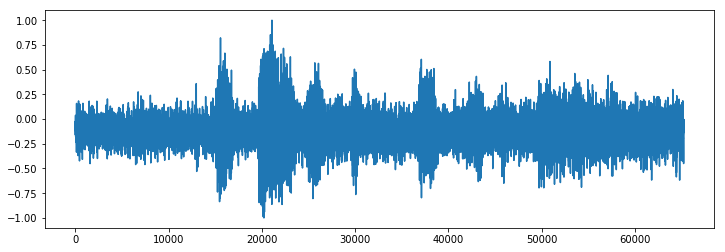

In [11]:
#  The original mixture
plt.figure(figsize=(12,4))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i].T, rate=sample_rate)

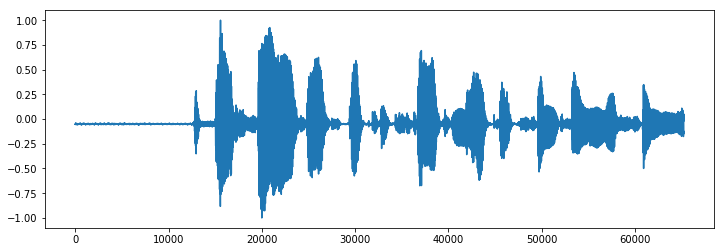

In [12]:
#  The original isolated voice
plt.figure(figsize=(12,4))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i].T, rate=sample_rate)

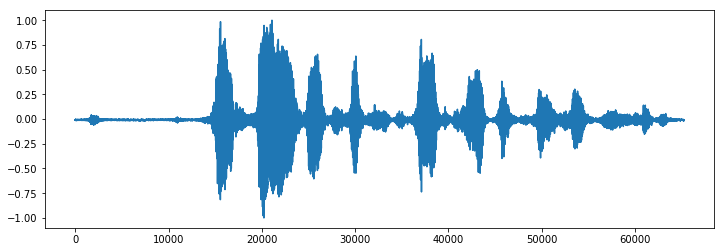

In [12]:
#  The estimated isolated voice produced by the network
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

In [13]:
# Save an audio file
folder = 'audio_examples'
sf.write(os.path.join(folder,'voice_est_unet_mag_phase_real_imag_example_308_1.wav'), mix_wave[i], sample_rate)

The cell below is used to overfit a model to a tiny data set, in order to test its basic ability to learn.

In [17]:
sess.run(pipe.initializer)
print('start: {}'.format(datetime.now()))
epochs = 1000
epoch = 0
epoch_cost = []
epoch_m_loss = []
epoch_p_loss = []
i = 0
while epoch < epochs:
    try:
        _, cost = sess.run([model.train_op, model.cost], {model.is_training:True})
        #_, cost, m_loss, p_loss = sess.run([model.train_op, model.cost, model.mag_loss, model.phase_loss], {model.is_training:True})
        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        epoch_cost.append(cost)
        #epoch_m_loss.append(m_loss)
        #epoch_p_loss.append(p_loss)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        #epoch_mean_m_loss = sum(epoch_m_loss)/len(epoch_m_loss)
        #epoch_mean_p_loss = sum(epoch_p_loss)/len(epoch_p_loss)
        print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        #print('\tMean magnitude loss = {emml}\n\tMean phase loss = {empl}'.format(emml=epoch_mean_m_loss,
        #                                                                       empl=epoch_mean_p_loss))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.now()))

start: 2019-02-11 10:51:10.848954
Epoch 0 finished. Mean cost = 0.39308398962020874
Epoch 1 finished. Mean cost = 0.39256225526332855
Epoch 2 finished. Mean cost = 0.3920529981454213
Epoch 3 finished. Mean cost = 0.3915483206510544
Epoch 4 finished. Mean cost = 0.39105030298233034
Epoch 5 finished. Mean cost = 0.3905518651008606
Epoch 6 finished. Mean cost = 0.39005586930683683
Epoch 7 finished. Mean cost = 0.3895612955093384
Epoch 8 finished. Mean cost = 0.389068603515625
Epoch 9 finished. Mean cost = 0.38857717216014864
Epoch 10 finished. Mean cost = 0.38808647339994257
Epoch 11 finished. Mean cost = 0.38759487370649975
Epoch 12 finished. Mean cost = 0.3871032641484187
Epoch 13 finished. Mean cost = 0.3866110146045685
Epoch 14 finished. Mean cost = 0.38611873785654705
Epoch 15 finished. Mean cost = 0.38562767021358013
Epoch 16 finished. Mean cost = 0.38513655522290396
Epoch 17 finished. Mean cost = 0.38464446200264824
Epoch 18 finished. Mean cost = 0.3841509191613448
Epoch 19 finishe

Epoch 162 finished. Mean cost = 0.3261096885233569
Epoch 163 finished. Mean cost = 0.3258822049673011
Epoch 164 finished. Mean cost = 0.3256564658699614
Epoch 165 finished. Mean cost = 0.32543274814105894
Epoch 166 finished. Mean cost = 0.3252110365265144
Epoch 167 finished. Mean cost = 0.32499111958202864
Epoch 168 finished. Mean cost = 0.3247730596178382
Epoch 169 finished. Mean cost = 0.3245569779592402
Epoch 170 finished. Mean cost = 0.3243429481286054
Epoch 171 finished. Mean cost = 0.3241310982510101
Epoch 172 finished. Mean cost = 0.32392171163090394
Epoch 173 finished. Mean cost = 0.3237134476845292
Epoch 174 finished. Mean cost = 0.3235067801816123
Epoch 175 finished. Mean cost = 0.3233022964136167
Epoch 176 finished. Mean cost = 0.32309951620586846
Epoch 177 finished. Mean cost = 0.3228985442874137
Epoch 178 finished. Mean cost = 0.32269902602254347
Epoch 179 finished. Mean cost = 0.32250068667862153
Epoch 180 finished. Mean cost = 0.32230386434339026
Epoch 181 finished. Mean

Epoch 322 finished. Mean cost = 0.30503832315881924
Epoch 323 finished. Mean cost = 0.3049643354283439
Epoch 324 finished. Mean cost = 0.3048905820112962
Epoch 325 finished. Mean cost = 0.3048172677221474
Epoch 326 finished. Mean cost = 0.3047443409578516
Epoch 327 finished. Mean cost = 0.3046717521984403
Epoch 328 finished. Mean cost = 0.3045995293417238
Epoch 329 finished. Mean cost = 0.3045277115070459
Epoch 330 finished. Mean cost = 0.3044563863212609
Epoch 331 finished. Mean cost = 0.30438572751829424
Epoch 332 finished. Mean cost = 0.30431566125637777
Epoch 333 finished. Mean cost = 0.30424561587993254
Epoch 334 finished. Mean cost = 0.3041759616403437
Epoch 335 finished. Mean cost = 0.304106666484759
Epoch 336 finished. Mean cost = 0.3040376573535738
Epoch 337 finished. Mean cost = 0.3039689929880334
Epoch 338 finished. Mean cost = 0.3039007234362374
Epoch 339 finished. Mean cost = 0.3038327794741182
Epoch 340 finished. Mean cost = 0.3037651772897614
Epoch 341 finished. Mean cos

Epoch 483 finished. Mean cost = 0.2967684712291749
Epoch 484 finished. Mean cost = 0.29673293478710133
Epoch 485 finished. Mean cost = 0.29669751680682227
Epoch 486 finished. Mean cost = 0.2966622983772897
Epoch 487 finished. Mean cost = 0.2966272498129821
Epoch 488 finished. Mean cost = 0.29659239847235885
Epoch 489 finished. Mean cost = 0.2965575207252892
Epoch 490 finished. Mean cost = 0.29652274365094916
Epoch 491 finished. Mean cost = 0.29648814404883034
Epoch 492 finished. Mean cost = 0.29645372966482
Epoch 493 finished. Mean cost = 0.2964194670379886
Epoch 494 finished. Mean cost = 0.29638531123748935
Epoch 495 finished. Mean cost = 0.2963512066391207
Epoch 496 finished. Mean cost = 0.2963172280692479
Epoch 497 finished. Mean cost = 0.2962833333566007
Epoch 498 finished. Mean cost = 0.29624964556617583
Epoch 499 finished. Mean cost = 0.2962160280942917
Epoch 500 finished. Mean cost = 0.2961825235875067
Epoch 501 finished. Mean cost = 0.296149252539137
Epoch 502 finished. Mean co

Epoch 643 finished. Mean cost = 0.29237920170800286
Epoch 644 finished. Mean cost = 0.2923579069995141
Epoch 645 finished. Mean cost = 0.29233668223254083
Epoch 646 finished. Mean cost = 0.29231550713779386
Epoch 647 finished. Mean cost = 0.2922943683778062
Epoch 648 finished. Mean cost = 0.2922733152867833
Epoch 649 finished. Mean cost = 0.29225237099023965
Epoch 650 finished. Mean cost = 0.2922316498928539
Epoch 651 finished. Mean cost = 0.2922110174971124
Epoch 652 finished. Mean cost = 0.292190364774482
Epoch 653 finished. Mean cost = 0.2921696687601393
Epoch 654 finished. Mean cost = 0.2921490589625963
Epoch 655 finished. Mean cost = 0.29212847710927814
Epoch 656 finished. Mean cost = 0.29210794493669423
Epoch 657 finished. Mean cost = 0.2920874546998178
Epoch 658 finished. Mean cost = 0.29206703750244223
Epoch 659 finished. Mean cost = 0.29204665128931856
Epoch 660 finished. Mean cost = 0.29202633370249426
Epoch 661 finished. Mean cost = 0.29200600096646395
Epoch 662 finished. Me

Epoch 804 finished. Mean cost = 0.28958013627840123
Epoch 805 finished. Mean cost = 0.2895659010478344
Epoch 806 finished. Mean cost = 0.28955168769114376
Epoch 807 finished. Mean cost = 0.28953748583646105
Epoch 808 finished. Mean cost = 0.2895233260907408
Epoch 809 finished. Mean cost = 0.28950920108659767
Epoch 810 finished. Mean cost = 0.289495120727619
Epoch 811 finished. Mean cost = 0.2894811063197446
Epoch 812 finished. Mean cost = 0.28946710981859347
Epoch 813 finished. Mean cost = 0.28945311687941633
Epoch 814 finished. Mean cost = 0.28943912225998253
Epoch 815 finished. Mean cost = 0.2894251772805172
Epoch 816 finished. Mean cost = 0.28941134077974456
Epoch 817 finished. Mean cost = 0.2893976385552609
Epoch 818 finished. Mean cost = 0.2893838940668164
Epoch 819 finished. Mean cost = 0.28937009125947954
Epoch 820 finished. Mean cost = 0.2893563139090149
Epoch 821 finished. Mean cost = 0.28934252033703517
Epoch 822 finished. Mean cost = 0.28932875843847655
Epoch 823 finished. M

Epoch 964 finished. Mean cost = 0.2876407190616884
Epoch 965 finished. Mean cost = 0.28763047863361013
Epoch 966 finished. Mean cost = 0.2876202236040425
Epoch 967 finished. Mean cost = 0.28760994699868286
Epoch 968 finished. Mean cost = 0.2875996590337271
Epoch 969 finished. Mean cost = 0.2875893795613161
Epoch 970 finished. Mean cost = 0.28757911874508885
Epoch 971 finished. Mean cost = 0.2875688997377093
Epoch 972 finished. Mean cost = 0.2875587306801854
Epoch 973 finished. Mean cost = 0.2875485813103662
Epoch 974 finished. Mean cost = 0.2875384325858874
Epoch 975 finished. Mean cost = 0.2875283121085558
Epoch 976 finished. Mean cost = 0.2875181918805551
Epoch 977 finished. Mean cost = 0.287508110144387
Epoch 978 finished. Mean cost = 0.28749806255071714
Epoch 979 finished. Mean cost = 0.2874880618586832
Epoch 980 finished. Mean cost = 0.28747803981394093
Epoch 981 finished. Mean cost = 0.2874679973314833
Epoch 982 finished. Mean cost = 0.28745795721197664
Epoch 983 finished. Mean c